In [1]:
import numpy as np
import torchvision
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from scipy.spatial.transform import Rotation as R

from numpy import genfromtxt

from low_altitude_nav.datasets.dataset import TerrainNavDataset
from low_altitude_nav.models.resnet_policy import ResNetPolicy
from low_altitude_nav.loss.relaxed_wta import RelaxedWTA
from low_altitude_nav.loss.collision_cost import CollisionCost
from low_altitude_nav.utils.esdf import ElevationMap


import yaml
import os
import sys
import matplotlib.pyplot as plt
import time
from IPython import display
import open3d as o3d
%matplotlib widget

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
class NetParams:
    def __init__(self, **entries):
        self.__dict__.update(entries)

In [3]:
checkpoints_path = "/home/yixuany/Downloads"
run_name = "bc_resnet_rgb_97ab7e99"
checkpoint_name = "epoch_130.pth"
with open(os.path.join(checkpoints_path, run_name, "config.yaml"), "r") as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

device='cuda'
model_config = config['model']
planner_net = ResNetPolicy(NetParams(**model_config)).to(device)
checkpoint = torch.load(os.path.join(checkpoints_path, run_name, checkpoint_name), map_location=device)
planner_net.load_state_dict(checkpoint['model_state_dict'])
planner_net.eval()

/home/yixuany/Workspace/LowAltitudeFlight/flight_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yixuany/Workspace/LowAltitudeFlight/flight_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_500371/2213215269.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See ht

ResNetPolicy(
  (depth_estimation_model): MultiViewDepthEstimator(
    (encoderF): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running

In [4]:
data_config = config['data']
train_config = config['train']
img_size = data_config['img_size']
expert_demo_dir = data_config['expert_demo_dir']
training_data_dir = data_config['training_data_dir']

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(img_size)
])
dataset = TerrainNavDataset(expert_demo_dir, training_data_dir, num_trajectories=1, transform=transform, preload=False, device=device)

Loading demonstrations: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

Number of data:  167
Finished creating dataset.


In [5]:
### Load TSDF Map
root_path = "/home/yixuany/Workspace/LowAltitudeFlight/TerrainCanyon/tsdf_map/"
map_name = "terrain_tsdf"
terrain_map = ElevationMap(device='cuda')
terrain_map.ReadTSDFMap(root_path, map_name)
collision_computation = CollisionCost(terrain_map, rq=5.0)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [6]:
trajectory_history = []
collision_cost_predictions = []
collision_cost_gts = []
for idx, (features, labels) in enumerate(data_loader):
    with torch.no_grad():
        rgb_img = features['rgb_img']
        rgb_tilted_img = features['rgb_tilted_img']
        heading = features['heading']
        attitude = features['attitude']
        position = features['position']

        desired_position = labels['desired_trajectory']
        depth_image = labels['depth_img']

        # Forward pass
        states = torch.cat((heading, attitude), dim=-1)
        student_path_local, collision_prediction, _, depth_img_prediction = planner_net(states, rgb_img, rgb_tilted_img)
        student_path_global = student_path_local + position[:, None, None, :]
        expert_path_global = desired_position + position[:, None, None, :]
        collision_prediction = collision_prediction.squeeze(dim=-1)

        expert_path = desired_position.unsqueeze(dim=1)
        collision_cost = collision_computation(student_path_global)
        collision_cost = collision_cost.to(device)

        student_path_global = student_path_global.detach().squeeze(dim=0).cpu().numpy()
        collision_cost = collision_cost.detach().squeeze(dim=0).cpu().numpy()
        collision_prediction = collision_prediction.detach().squeeze(dim=0).cpu().numpy()

        trajectory_history.append(student_path_global)
        collision_cost_predictions.append(collision_prediction)
        collision_cost_gts.append(collision_cost)
        break
trajectory_history = np.asarray(trajectory_history)
collision_cost_predictions = np.asarray(collision_cost_predictions)
collision_cost_gts = np.asarray(collision_cost_gts)
expert_path_global = expert_path_global.detach().squeeze(dim=0).squeeze(dim=0).cpu().numpy()
depth_img = depth_image.squeeze().cpu().numpy()
prediction_depth = depth_img_prediction.squeeze().cpu().numpy()


Visualize planned path. Expert demo is makred with blue color and student path is marked with green color.

In [7]:
vis = [terrain_map.pcd_tsdf]
idx = 0
for j in range(trajectory_history.shape[2]):
    point = o3d.geometry.TriangleMesh.create_sphere(radius=2.0, resolution=10)
    point.translate(trajectory_history[idx, 0, j, :] - point.get_center())
    point.paint_uniform_color([0, 1, 0])
    vis.append(point)

for i in range(expert_path_global.shape[0]):
    point = o3d.geometry.TriangleMesh.create_sphere(radius=2.0, resolution=10)
    point.translate(expert_path_global[i, :] - point.get_center())
    point.paint_uniform_color([0, 0, 1])
    vis.append(point)

o3d.visualization.draw_geometries(vis)

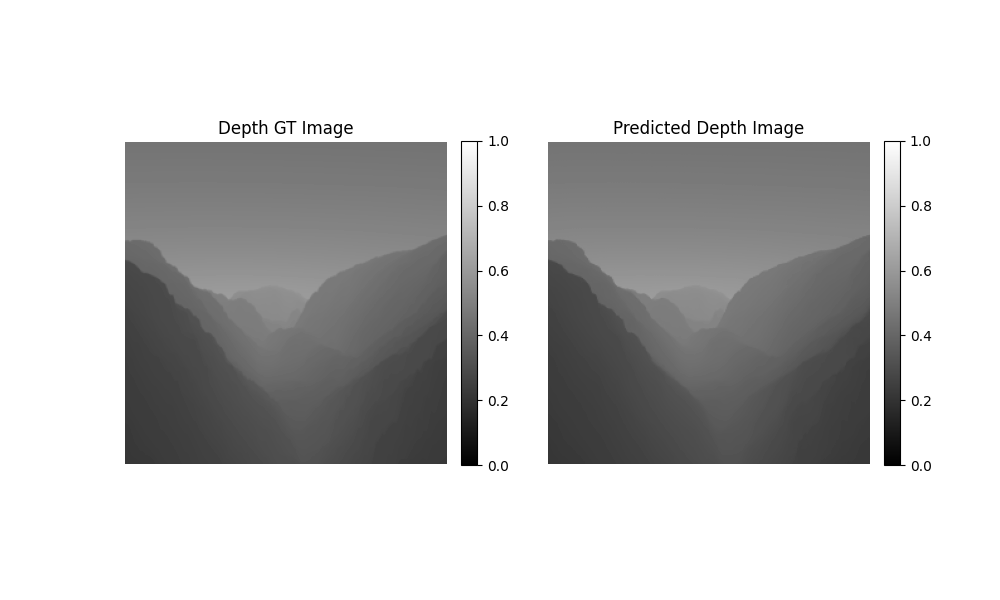

In [8]:
# Initialize the plot
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Display initial images
depth_gt_plot = axes[0].imshow(depth_img, vmin=0.0, vmax=1.0, cmap='gray')
axes[0].set_title("Depth GT Image")
axes[0].axis("off")
cb = plt.colorbar(depth_gt_plot, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

depth_plot = axes[1].imshow(prediction_depth, vmin=0.0, vmax=1.0, cmap='gray')
axes[1].set_title("Predicted Depth Image")
axes[1].axis("off")
cb = plt.colorbar(depth_plot, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
